In [10]:
import sys
sys.path.append('../..')
import os
from tqdm import tqdm
from config import client
from pymongo import MongoClient
import pandas as pd
import torch
import matplotlib.pyplot as plt
import math
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from mlpp.data_modeling.preliminary_modeling import get_dataframe
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
osu_db = client['osu_random_db']

In [39]:
df = get_dataframe(osu_db.week_9_sample_users, osu_db.osu_scores_high, osu_db.osu_beatmaps)
df.head()

,count50,count100,count300,countmiss,countgeki,countkatu,perfect,countNormal,countSlider,countSpinner,countTotal,diff_approach,diff_drain,diff_overall,diff_size,hit_length,est_user_pp
0,2,76,133,5,4,20,0,155,60,1,278,5.0,4.0,5.0,5.0,155,114.756841
1,6,24,70,5,14,11,0,79,24,2,133,5.0,5.0,5.0,5.0,64,132.594611
2,2,7,185,1,36,5,0,158,37,0,232,3.0,2.0,3.0,3.0,209,63.021358
3,2,19,230,11,63,11,0,249,12,1,276,4.0,3.0,4.0,5.0,145,61.159836
4,5,41,87,9,38,19,0,92,44,6,198,5.0,5.0,5.0,6.0,129,57.935610


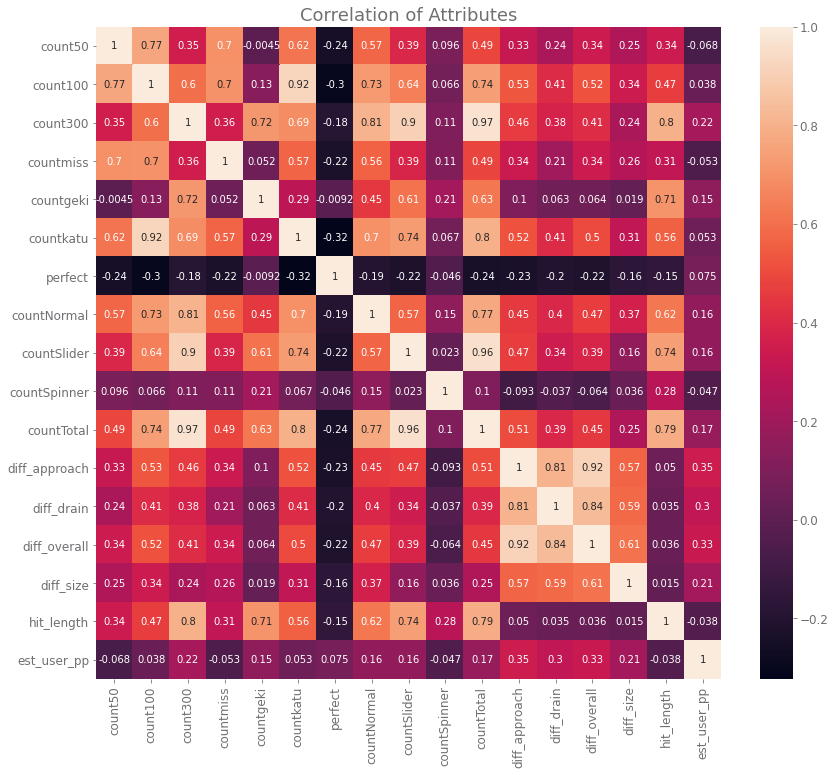

In [7]:
correlation = df.astype('float64').corr()
f, ax = plt.subplots(figsize = (14, 12))
plt.title("Correlation of Attributes")
sns.heatmap(correlation, annot = True)
plt.show()

From this point on, the code is taken from https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [11]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [14]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=2)

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [17]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [18]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [26]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=16, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
loss_stats = {
    'train': [],
    "val": []
}

In [31]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 2478.91076 | Val Loss: 2422.22427
Epoch 002: | Train Loss: 2431.40548 | Val Loss: 2387.44561
Epoch 003: | Train Loss: 2401.54486 | Val Loss: 2367.15854
Epoch 004: | Train Loss: 2382.99559 | Val Loss: 2353.96467
Epoch 005: | Train Loss: 2370.21382 | Val Loss: 2342.59841
Epoch 006: | Train Loss: 2359.41142 | Val Loss: 2337.25873
Epoch 007: | Train Loss: 2354.07805 | Val Loss: 2349.04253
Epoch 008: | Train Loss: 2353.61245 | Val Loss: 2330.84436
Epoch 009: | Train Loss: 2346.75223 | Val Loss: 2337.25308
Epoch 010: | Train Loss: 2344.01811 | Val Loss: 2352.24077
Epoch 011: | Train Loss: 2343.11000 | Val Loss: 2324.26713
Epoch 012: | Train Loss: 2342.66396 | Val Loss: 2328.16958
Epoch 013: | Train Loss: 2342.11595 | Val Loss: 2341.07850
Epoch 014: | Train Loss: 2341.57335 | Val Loss: 2324.34194
Epoch 015: | Train Loss: 2336.87169 | Val Loss: 2322.65871
Epoch 016: | Train Loss: 2337.45572 | Val Loss: 2327.77701
Epoch 017: | Train Loss: 2333.63868 | Val Loss: 2320.783

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

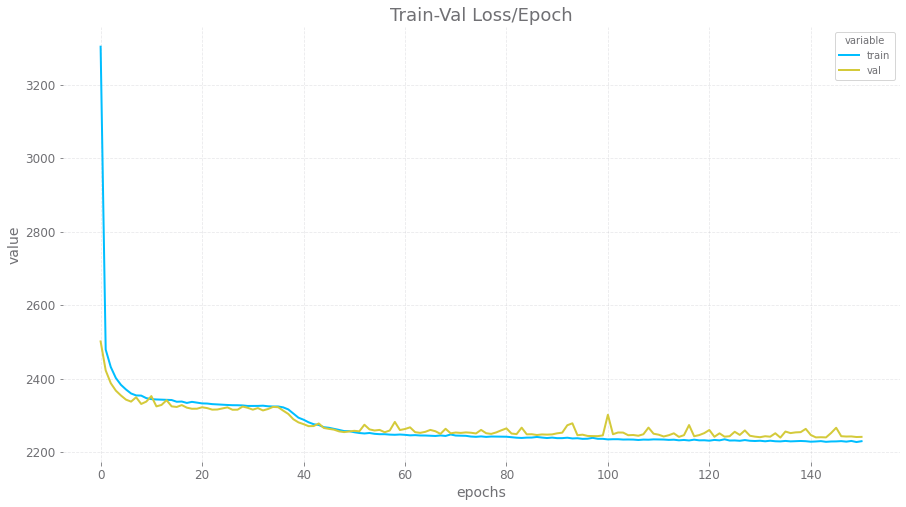

In [32]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [33]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [38]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred_list))
print("Root Mean Squared Error :", rmse)

Root Mean Squared Error : 46.78105857359265
